In [15]:
#GNN and linear
import torch #tensors
import torch.nn as nn #weight and bias
import torch.nn.functional as F #activation functions
from torch.optim import SGD
from torch_geometric.data import Data #graph data structure
from torch.optim import SGD

#Random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

import csv
import pandas as pd
from collections import defaultdict
import numpy as np

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable

In [3]:
rosettes = [3,6,7,11,12,13,14,15,18,19]

### Create graph

In [9]:
def graph_r(r):

    nodes = []
    edges = []
    edges_distances = []

    with open(f'./data/rosette{r}_nodes.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                values = list(row.values())
                n = []
                n.append(float(values[0]))
                n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))
                n.append(float(values[-1]))
                nodes.append(n)

    with open(f'./data/rosette{r}_edges.csv', mode='r') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            if (row!=0):
                edges_distances.append([float(n) for n in list(row.values())])
                edges.append([float(n) for n in list(row.values())][:2])

    return (nodes,edges,edges_distances)

In [5]:
nodes, edges, distances = graph_r(rosettes[0])

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_28738/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


In [6]:
node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

### Correlation matrix

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))
/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/1444036664.py:8: RuntimeWarning: divide by zero encountered in log10
  ed = [np.log10(c[n[0]]) for n in nodes]


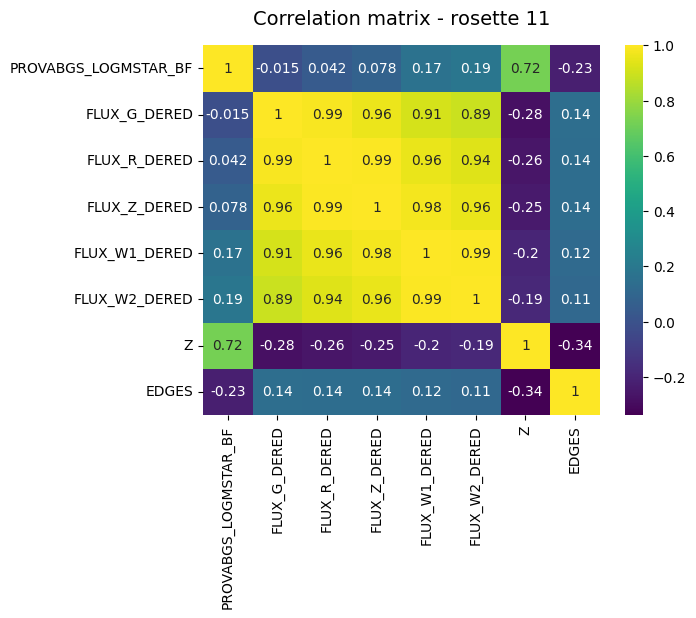

In [8]:
def correlation_matrix(r,nodes,edges):

    df = pd.read_csv(f'./data/rosette{r}_nodes.csv')
    c = defaultdict(int)
    for edge in edges:
        c[edge[0]] += 1
        c[edge[1]] += 1
    ed = [np.log10(c[n[0]]) for n in nodes]
    df['EDGES'] = ed

    df.drop('TARGET_ID', axis=1, inplace=True)
    matrix = sb.heatmap(df.corr(), cmap="viridis", annot=True)
    matrix.set_title(f'Correlation matrix - rosette {r}', fontsize=14, pad=15)
    plt.show()

nodes, edges, _ = graph_r(11)
correlation_matrix(11,nodes,edges)

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


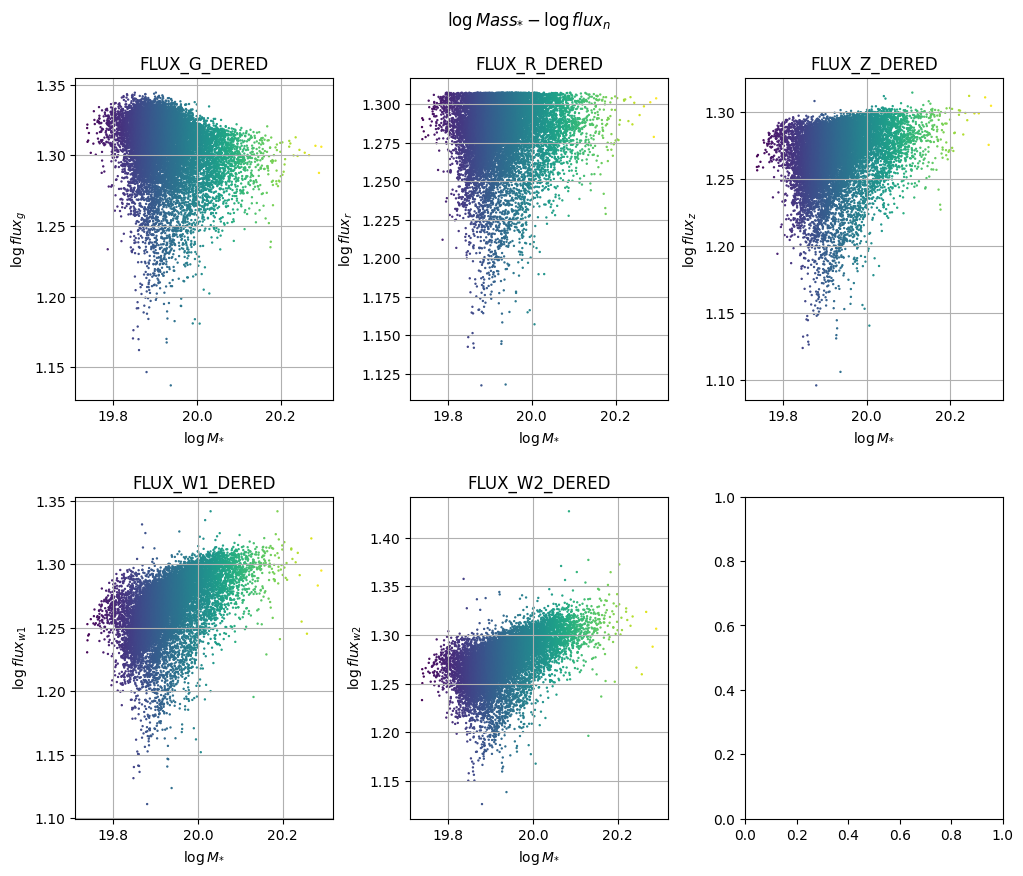

In [9]:
nodes, edges, _ = graph_r(11)

c = defaultdict(int)
for edge in edges:
    c[edge[0]] += 1
    c[edge[1]] += 1
m = [n[1] for n in nodes]
ed = [c[n[0]] for n in nodes]

f_g = np.log10([n[2] for n in nodes])
f_r = np.log10([n[3] for n in nodes])
f_z = np.log10([n[4] for n in nodes])
f_w1 = np.log10([n[5] for n in nodes])
f_w2 = np.log10([n[6] for n in nodes])

cmap = cm.viridis
n = (m - np.min(m)) / (np.max(m) - np.min(m))
min_norm = np.min(m)
max_norm = np.max(m)
sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_norm, vmax=max_norm))
sm.set_array([])

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

axes[0, 0].scatter(m, f_g, marker='o', c=cmap(n), s=0.5)
axes[0, 0].set_title('FLUX_G_DERED')
axes[0, 0].set_xlabel(r'$\log M_{*}$')
axes[0, 0].set_ylabel(r'$\log flux_{g}$')
axes[0, 0].grid()

axes[0, 1].scatter(m, f_r, marker='o', c=cmap(n), s=0.5)
axes[0, 1].set_title('FLUX_R_DERED')
axes[0, 1].set_xlabel(r'$\log M_{*}$')
axes[0, 1].set_ylabel(r'$\log flux_{r}$')
axes[0, 1].grid()

axes[0, 2].scatter(m, f_z, marker='o', c=cmap(n), s=0.5)
axes[0, 2].set_title('FLUX_Z_DERED')
axes[0, 2].set_xlabel(r'$\log M_{*}$')
axes[0, 2].set_ylabel(r'$\log flux_{z}$')
axes[0, 2].grid()

axes[1, 0].scatter(m, f_w1, marker='o', c=cmap(n), s=0.5)
axes[1, 0].set_title('FLUX_W1_DERED')
axes[1, 0].set_xlabel(r'$\log M_{*}$')
axes[1, 0].set_ylabel(r'$\log flux_{w1}$')
axes[1, 0].grid()

axes[1, 1].scatter(m, f_w2, marker='o', c=cmap(n), s=0.5)
axes[1, 1].set_title('FLUX_W2_DERED')
axes[1, 1].set_xlabel(r'$\log M_{*}$')
axes[1, 1].set_ylabel(r'$\log flux_{w2}$')
axes[1, 1].grid()

plt.show()

## Models

### Linear Model

In [10]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

input_size = 6 #galaxy prop [flux g, flux r, flux z, flux w1, flux w2, z]
output_size = 1  #mass

model = LinearRegression(input_size, output_size)

In [11]:
criterion = nn.MSELoss()  #Mean squared error loss function
optimizer = SGD(model.parameters(), lr=0.001)  #Stochastic gradient descent

Including **all** [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [12]:
num_epochs = 100
training_r = [3,6,7,11,12] #training

for r in training_r:
    inputs = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
    targets = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]

    inputs = torch.tensor(inputs, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32)

    for epoch in range(num_epochs):
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print(f'Epoch [{epoch + 1}/{num_epochs}], loss: {loss.item():.2f}')

nodes, edges, distances = graph_r(rosettes[5])
new_data = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes] #rosette 13 test
test = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]

new_data = torch.tensor(new_data, dtype=torch.float32)
test = torch.tensor(test, dtype=torch.float32)

with torch.no_grad(): #Test new
    predictions = model(new_data)

mse = criterion(predictions, test)
print(f'error: {mse.item()}')

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


error: nan


Including **one** of [flux_g, flux_r, flux_z, flux_w1, flux_w2, z]

In [101]:
num_epochs = 100
props = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']
training_r = [3,6] #training
pred = []
values = []
lr = np.linspace(0.0001,0.01,50)

for i in range(5,6):
    for l in lr:
        class LinearRegression(nn.Module):
            def __init__(self, input_size, output_size):
                super(LinearRegression, self).__init__()
                self.linear = nn.Linear(input_size, output_size)

            def forward(self, x):
                return self.linear(x)

        input_size = 1 #galaxya prop, just one [flux g, flux r, flux z, flux w1, flux w2, z]
        output_size = 1  #mass

        model = LinearRegression(input_size, output_size)
        criterion = nn.MSELoss()  #Mean squared error loss function

        optimizer = SGD(model.parameters(), lr=l)  #Stochastic gradient descent

        for r in training_r:

            nodes, _, _ = graph_r(r)

            inputs = np.array([[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes])
            inputs_i = torch.tensor(inputs[:,i], dtype=torch.float32).unsqueeze(1)

            targets = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]
            targets = torch.tensor(targets, dtype=torch.float32)

            for epoch in range(num_epochs):
                outputs = model(inputs_i)
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            nodes, _, _ = graph_r(rosettes[7])
            new_data = np.array([[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]) #rosette 15 test
            test = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]

            new_data = torch.tensor(new_data[:,i], dtype=torch.float32).unsqueeze(1)
            test = torch.tensor(test, dtype=torch.float32)

            with torch.no_grad(): #Test new
                predictions = model(new_data)
                pred.append(predictions)

            mse = criterion(predictions, test)
            #print(f'error {props[i]}: {mse.item()}')
            values.append((l,mse.item()))

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


Text(0, 0.5, 'mean squared error')

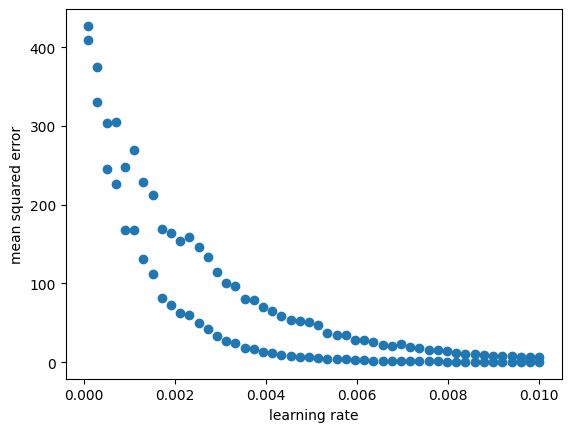

In [102]:
fg = np.array(values)
#fr = values[20:40]
#fz = values[40:60]
#fw1 = values[60:80]
#fw2 = values[80:100]
#z = values[100:]

plt.scatter(fg[:,0], fg[:,1])
plt.xlabel('learning rate')
plt.ylabel('mean squared error')

In [103]:
for i in range(len(props)):
    class LinearRegression(nn.Module):
        def __init__(self, input_size, output_size):
            super(LinearRegression, self).__init__()
            self.linear = nn.Linear(input_size, output_size)

        def forward(self, x):
            return self.linear(x)

    input_size = 1 #galaxya prop, just one [flux g, flux r, flux z, flux w1, flux w2, z]
    output_size = 1  #mass

    model = LinearRegression(input_size, output_size)
    criterion = nn.MSELoss()  #Mean squared error loss function

    optimizer = SGD(model.parameters(), lr=0.004)  #Stochastic gradient descent

    for r in training_r:

        nodes, _, _ = graph_r(r)

        inputs = np.array([[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes])
        inputs_i = torch.tensor(inputs[:,i], dtype=torch.float32).unsqueeze(1)

        targets = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]
        targets = torch.tensor(targets, dtype=torch.float32)

        for epoch in range(num_epochs):
            outputs = model(inputs_i)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        nodes, _, _ = graph_r(rosettes[7])
        new_data = np.array([[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]) #rosette 15 test
        test = [[mass] for [_, mass, _, _, _, _, _, _] in nodes]

        new_data = torch.tensor(new_data[:,i], dtype=torch.float32).unsqueeze(1)
        test = torch.tensor(test, dtype=torch.float32)

        with torch.no_grad(): #Test new
            predictions = model(new_data)
            pred.append(predictions)

        mse = criterion(predictions, test)
        print(f'error {props[i]}: {mse.item()}')

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


error flux_g: inf
error flux_g: nan
error flux_r: inf
error flux_r: nan
error flux_z: inf
error flux_z: nan
error flux_w1: nan
error flux_w1: nan
error flux_w2: nan
error flux_w2: nan
error z: 76.28136444091797
error z: 14.533655166625977


/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_76970/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


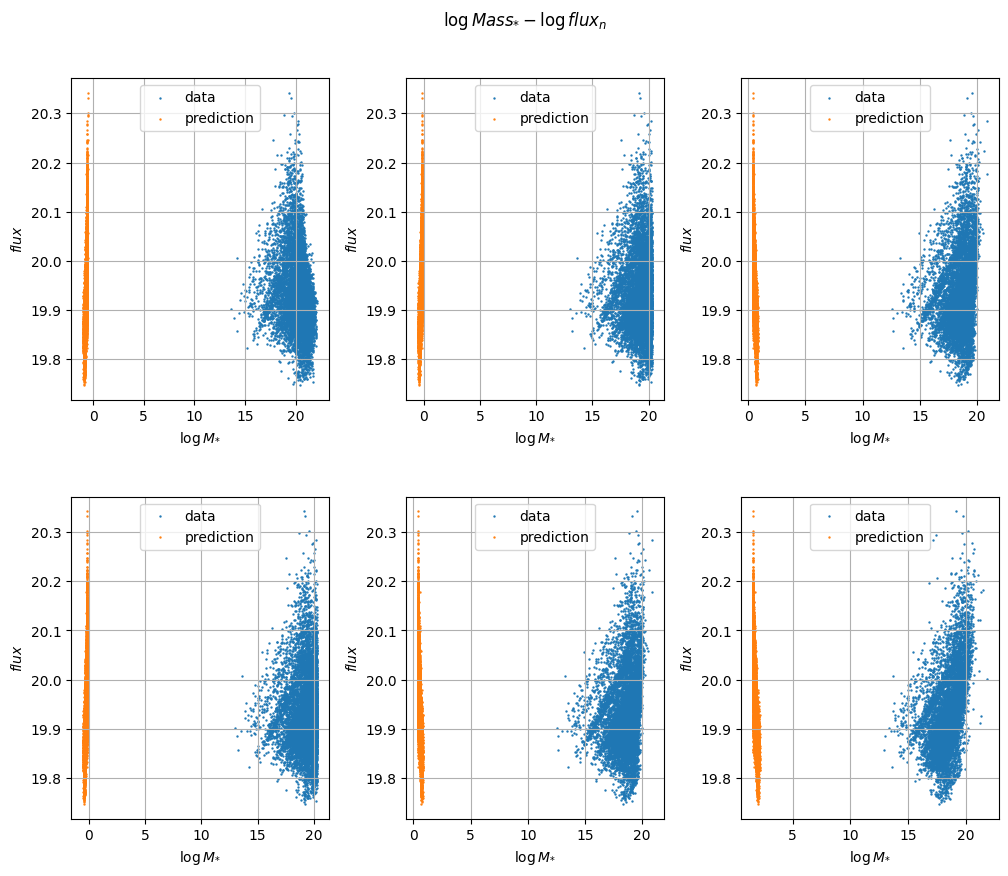

In [104]:
nodes, _, _ = graph_r(rosettes[7])
m = [mass for [_, mass, _, _, _, _, _, _] in nodes]
flux = np.array([[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes])

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(2):
    for j in range(3):
        axes[i, j].scatter(flux[:,i+j], m, s=0.5, label='data') #data
        axes[i, j].scatter(pred[i + j].numpy(), m, s=0.5, label='prediction') #predictions
        axes[i, j].legend()
        axes[i, j].set_title('')
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(r'$flux$')
        axes[i, j].grid()

plt.show()

### Random Forest

In [14]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)
regressor = RandomForestRegressor(n_estimators=100, random_state=42)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_28738/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


ValueError: Input X contains NaN.
RandomForestRegressor does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [21]:
nodes, _, _ = graph_r(rosettes[0])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]

X = np.array(X)
np.count_nonzero(np.isnan(X))

/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_28738/2401243092.py:14: RuntimeWarning: invalid value encountered in log10
  n.extend(22.5-2.5*np.log10([float(n) for n in list(values)[1:-1]]))


36

In [ ]:
nodes, _, _ = graph_r(rosettes[1])
X = [[flux_g, flux_r, flux_z, flux_w1, flux_w2, z] for [_, _, flux_g, flux_r, flux_z, flux_w1, flux_w2, z] in nodes]
y = [mass for [_, mass, _, _, _, _, _, _] in nodes]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.999, random_state=42)

y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.04314547182227776


/var/folders/ls/yc9nb2gx14s6sstnjr_fcy5r0000gn/T/ipykernel_91889/850457415.py:1: RuntimeWarning: invalid value encountered in log10
  X_test = np.log10(np.array(X_test))


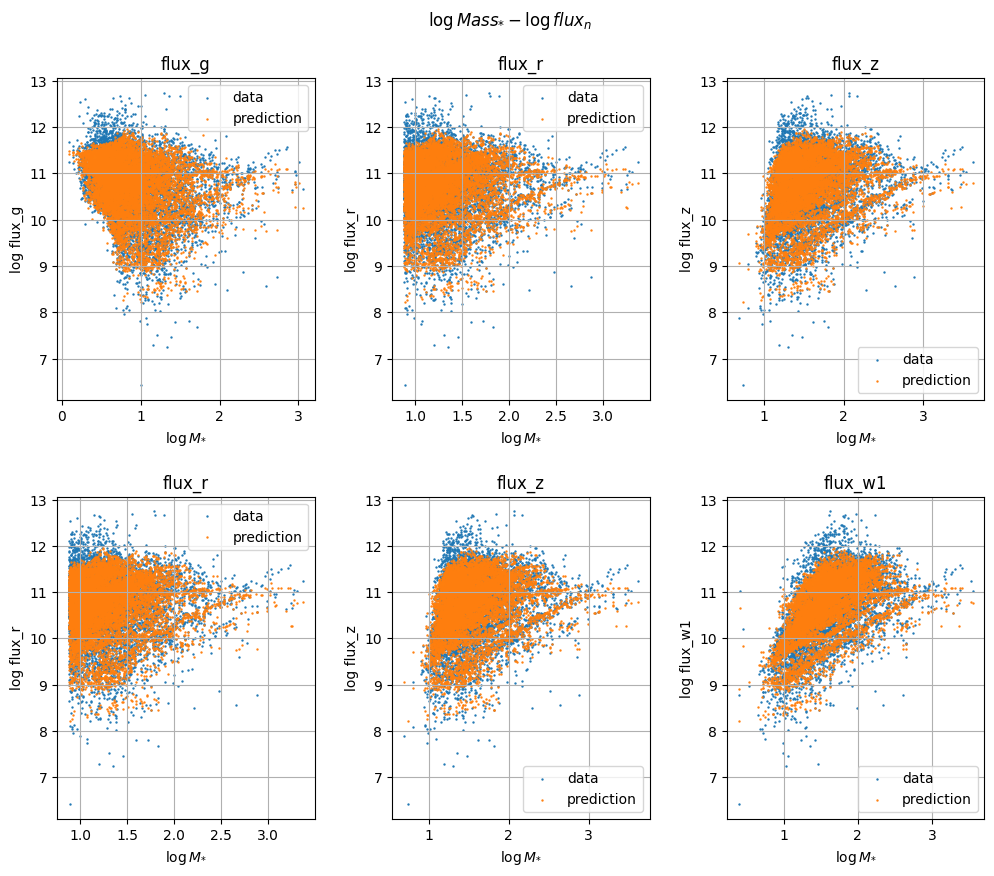

In [ ]:
X_test = np.log10(np.array(X_test))
labels = ['flux_g', 'flux_r', 'flux_z', 'flux_w1', 'flux_w2', 'z']

nrows, ncols =  3, 2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 8))
plt.tight_layout()
plt.suptitle(r'$\log{Mass_{*}} - \log{flux_{n}}$', y=1.06)
plt.subplots_adjust(wspace=0.3, hspace=0.3)

for i in range(2):
    for j in range(3):
        axes[i, j].scatter(X_test[:,i+j], y_test, s=0.5, label='data') #data
        axes[i, j].scatter(X_test[:,i + j], y_pred, s=0.5, label='prediction') #predictions
        axes[i, j].legend()
        axes[i, j].set_title(labels[i+j])
        axes[i, j].set_xlabel(r'$\log M_{*}$')
        axes[i, j].set_ylabel(f'log {labels[i+j]}')
        axes[i, j].grid()

plt.show()

### Graph Neural Network (GNN)

In [ ]:
nodes, edges, distances = graph_r(rosettes[0])

node_features = torch.tensor(nodes, dtype=torch.float)
edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

graph = Data(x=node_features, edge_index=edge_index)
graph.num_nodes = len(nodes)
graph.num_edges = len(edges)

In [ ]:
class GNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleGNN, self).__init__()
        self.conv1 = nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = nn.GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)

        return x